# Overview of HydroGym features

In [1]:
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import firedrake as fd
import hydrogym as gym

precomputed_data = '../examples/cylinder/output'

# High-level interface

The highest-level interface is an implementation of the OpenAI gym `Env` called `FlowEnv`, where you have to do almost nothing to run the simulation.  We can optionally load from a previous checkpoint, which we'll do here to save time.

In [2]:
env = gym.env.CylEnv(f'{precomputed_data}/checkpoint.h5')

Firedrake has a [full set of plotting tools](https://www.firedrakeproject.org/_modules/firedrake/plot.html) built on matplotlib, but as an easy way to see what's going on, the `FlowEnv` can also render the flow and plot vorticity.

For a much more powerful set of visualization tools, the fields can also be written out to Paraview.  We'll come back to that later.

/home/firedrake/firedrake/lib/python3.8/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


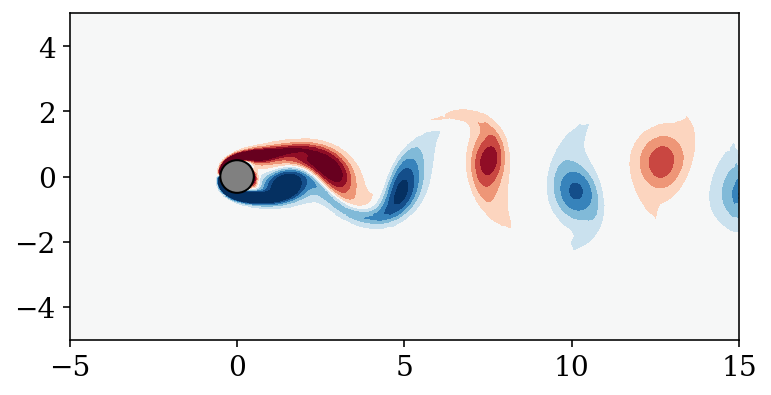

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6, 3))
env.render(axes=ax)
plt.show()

Keyword arguments are passed on to firedrake and then matplotlib, so the behavior is similar to what you'd expect for `matplotlib.contourf`

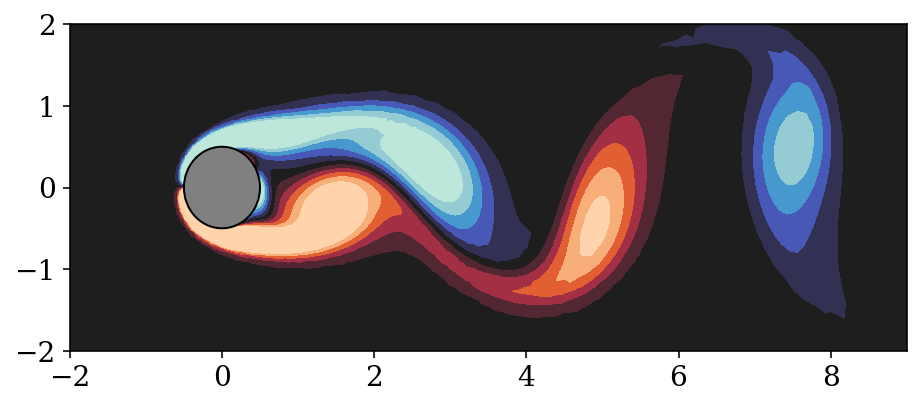

In [4]:
fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
env.render(axes=ax, cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-2, 9])
ax.set_ylim([-2, 2])
plt.show()

We can easily step the simulation forward in time by calling the `step` method.  This takes as an optional input the control "action" (more on this in a minute).  If not supplied the flow will just evolve naturally.

`step` returns a tuple of `(obs, reward, done, info)`.  For the cylinder the observations are the lift and drag coefficients.  Since the objective is drag minimization, `reward` is negative drag (maximizing negative drag = minimizing drag).  As of now `done` and `info` are not implemented.

The vortex shedding period is about 5.6, so let's run it for about half of that and compare to the previous state.

In [5]:
# Runtime: 3m
Tf = 2.8
num_steps = int(Tf//env.solver.dt)
for i in range(num_steps):
    (CL, CD), _, _, _ = env.step()  # obs, reward, done, info
    print(f'Step: {i+1}/{num_steps},\tLift: {CL:0.3f},\tDrag: {CD:0.3f}')

Step: 1/279,	Lift: -0.236,	Drag: 1.502
Step: 2/279,	Lift: -0.232,	Drag: 1.502
Step: 3/279,	Lift: -0.229,	Drag: 1.502
Step: 4/279,	Lift: -0.226,	Drag: 1.502
Step: 5/279,	Lift: -0.222,	Drag: 1.501
Step: 6/279,	Lift: -0.219,	Drag: 1.501
Step: 7/279,	Lift: -0.215,	Drag: 1.501
Step: 8/279,	Lift: -0.212,	Drag: 1.501
Step: 9/279,	Lift: -0.208,	Drag: 1.500
Step: 10/279,	Lift: -0.205,	Drag: 1.500
Step: 11/279,	Lift: -0.201,	Drag: 1.500
Step: 12/279,	Lift: -0.198,	Drag: 1.500
Step: 13/279,	Lift: -0.194,	Drag: 1.499
Step: 14/279,	Lift: -0.190,	Drag: 1.499
Step: 15/279,	Lift: -0.187,	Drag: 1.499
Step: 16/279,	Lift: -0.183,	Drag: 1.499
Step: 17/279,	Lift: -0.179,	Drag: 1.498
Step: 18/279,	Lift: -0.175,	Drag: 1.498
Step: 19/279,	Lift: -0.172,	Drag: 1.498
Step: 20/279,	Lift: -0.168,	Drag: 1.497
Step: 21/279,	Lift: -0.164,	Drag: 1.497
Step: 22/279,	Lift: -0.160,	Drag: 1.497
Step: 23/279,	Lift: -0.156,	Drag: 1.497
Step: 24/279,	Lift: -0.153,	Drag: 1.496
Step: 25/279,	Lift: -0.149,	Drag: 1.496
Step: 26/

The vortex shedding has advanced by about half a period compared to the initial state.

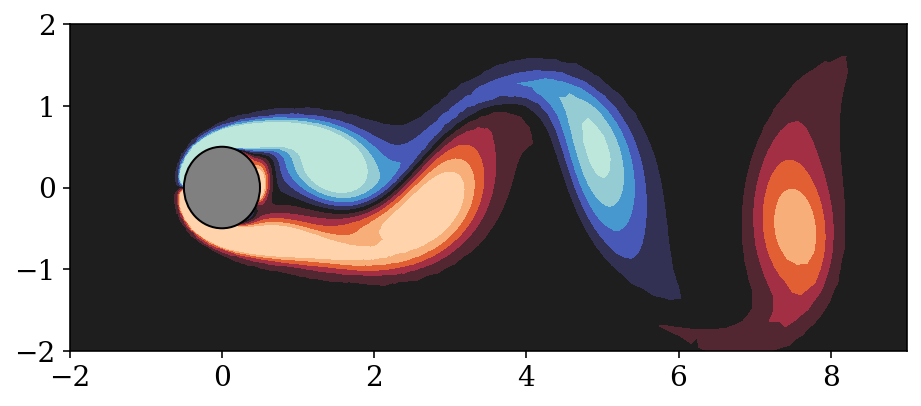

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
env.render(axes=ax, cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-2, 9])
ax.set_ylim([-2, 2])
plt.show()

As usual with `Env` objects, we can `reset` to the initial state if we want.

(-2.0, 2.0)

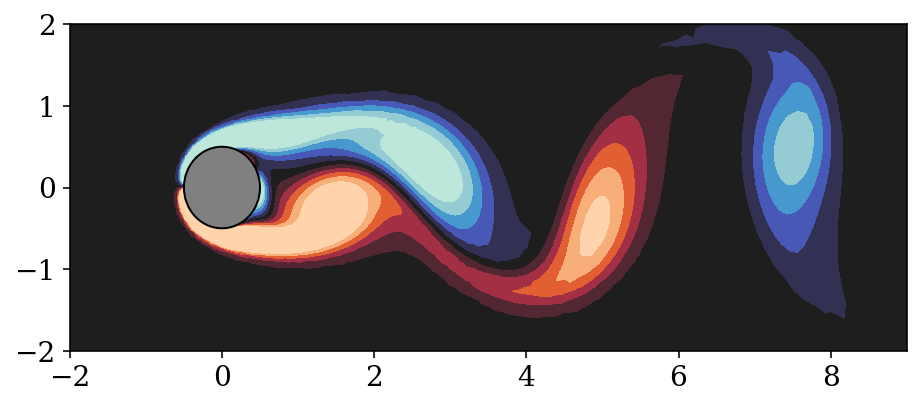

In [7]:
CL, CD = env.reset()
fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
env.render(axes=ax, cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-2, 9])
ax.set_ylim([-2, 2])

### Adding control

The cylinder case has a single control, which is the rotation rate of the cylinder.  Often the goal will be to derive some open-loop or closed-loop control strategy that can minimize the drag, but to see how it works we can just define a constant `action` and re-run the simulation.  Note how different the lift/drag numbers are from the "natural" dynamics and the deflection of the vortex shedding compared to the previous simulation

In [8]:
# Runtime: 3m
Tf = 2.8
num_steps = int(Tf//env.solver.dt)
env.reset()
action = 0.5  # Rotation rate in rad/s
for i in range(num_steps):
    (CL, CD), _, _, _ = env.step(action)  # obs, reward, done, info
    print(f'Step: {i+1}/{num_steps},\tLift: {CL:0.3f},\tDrag: {CD:0.3f}')

Step: 1/279,	Lift: 0.115,	Drag: 1.497
Step: 2/279,	Lift: -0.256,	Drag: 1.461
Step: 3/279,	Lift: -0.502,	Drag: 1.451
Step: 4/279,	Lift: -0.410,	Drag: 1.461
Step: 5/279,	Lift: -0.427,	Drag: 1.456
Step: 6/279,	Lift: -0.396,	Drag: 1.464
Step: 7/279,	Lift: -0.407,	Drag: 1.459
Step: 8/279,	Lift: -0.392,	Drag: 1.465
Step: 9/279,	Lift: -0.398,	Drag: 1.461
Step: 10/279,	Lift: -0.390,	Drag: 1.465
Step: 11/279,	Lift: -0.394,	Drag: 1.463
Step: 12/279,	Lift: -0.390,	Drag: 1.465
Step: 13/279,	Lift: -0.393,	Drag: 1.463
Step: 14/279,	Lift: -0.392,	Drag: 1.464
Step: 15/279,	Lift: -0.395,	Drag: 1.463
Step: 16/279,	Lift: -0.395,	Drag: 1.463
Step: 17/279,	Lift: -0.398,	Drag: 1.462
Step: 18/279,	Lift: -0.399,	Drag: 1.462
Step: 19/279,	Lift: -0.402,	Drag: 1.461
Step: 20/279,	Lift: -0.404,	Drag: 1.461
Step: 21/279,	Lift: -0.407,	Drag: 1.459
Step: 22/279,	Lift: -0.410,	Drag: 1.459
Step: 23/279,	Lift: -0.413,	Drag: 1.458
Step: 24/279,	Lift: -0.417,	Drag: 1.457
Step: 25/279,	Lift: -0.420,	Drag: 1.456
Step: 26/2

(-2.0, 2.0)

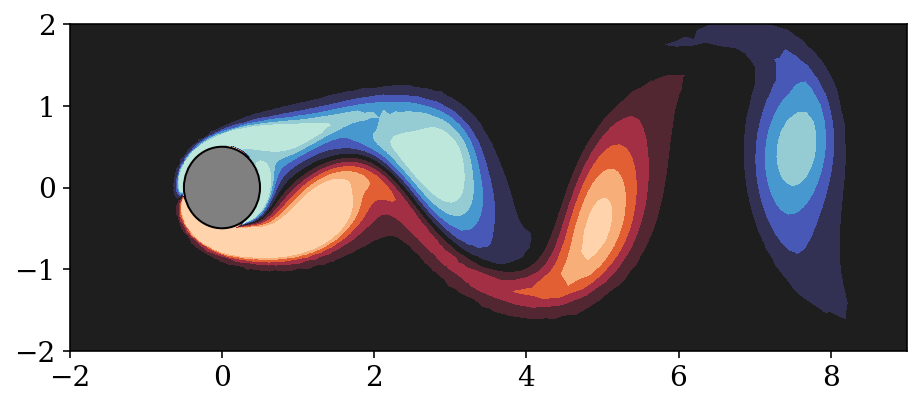

In [9]:
fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
env.render(axes=ax, cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-2, 9])
ax.set_ylim([-2, 2])

# Under the hood

The `FlowEnv` is actually just a wrapper around two other objects that give finer-grained control: the `FlowConfig` and `TransientSolver` classes.

The default solver is called an "Incremental Pressure Correction Scheme" (IPCS), although support for other timestepping methods is planned.

In [10]:
env.flow, env.solver

(<hydrogym.flow.cylinder.Cylinder at 0x7f611e1ff5e0>,
 <hydrogym.ts.IPCS at 0x7f60d78a22e0>)

In [11]:
isinstance(env.flow, gym.core.FlowConfig), isinstance(env.solver, gym.ts.TransientSolver)

(True, True)

The solver can be advanced on its own in almost the exact same way as the `FlowEnv`, except you have to input controls and read out observations manually.  So these two are exactly equivalent:

In [12]:
num_steps = 5

print("Advancing with `FlowEnv`")
env.reset()
for i in range(num_steps):
    (CL, CD), _, _, _ = env.step()
    print(f'\tStep: {i+1}/{num_steps},\tLift: {CL:0.3f},\tDrag: {CD:0.3f}')
    
print("Advancing with `env.solver`")
env.reset()
for i in range(num_steps):
    env.solver.step(i)
    (CL, CD) = env.flow.collect_observations()
    print(f'\tStep: {i+1}/{num_steps},\tLift: {CL:0.3f},\tDrag: {CD:0.3f}')

Advancing with `FlowEnv`
	Step: 1/5,	Lift: -0.374,	Drag: 1.760
	Step: 2/5,	Lift: -0.024,	Drag: 1.679
	Step: 3/5,	Lift: 0.225,	Drag: 1.661
	Step: 4/5,	Lift: 0.140,	Drag: 1.658
	Step: 5/5,	Lift: 0.165,	Drag: 1.654
Advancing with `env.solver`
	Step: 1/5,	Lift: 0.139,	Drag: 1.653
	Step: 2/5,	Lift: 0.158,	Drag: 1.653
	Step: 3/5,	Lift: 0.148,	Drag: 1.651
	Step: 4/5,	Lift: 0.161,	Drag: 1.652
	Step: 5/5,	Lift: 0.158,	Drag: 1.651


Working at this level the `FlowEnv` can be ignored altogether.  In this case there is an `integrate` method in the `ts` module that will advance the flow.

In [13]:
dt = env.solver.dt  # To be consistent with the previous cell
flow = gym.flow.Cylinder(h5_file=f'{precomputed_data}/checkpoint.h5')  # Same initial state as the `FlowEnv`
flow = gym.ts.integrate(flow, t_span=(0, num_steps*dt), dt=dt)
CL, CD = flow.compute_forces()   # Compute lift/drag, just as with env.collect_observations()
print(f'Lift: {CL:0.3f},\tDrag: {CD:0.3f}')

Lift: -0.222,	Drag: 1.501


The `FlowConfig` also gives you much more access.  For instance, we can use a Newton solver to find the unstable symmetric state of the flow.

In [14]:
# Runtime: 10s
cyl = gym.flow.Cylinder()
qB = cyl.solve_steady()  # Base flow: [u, p]

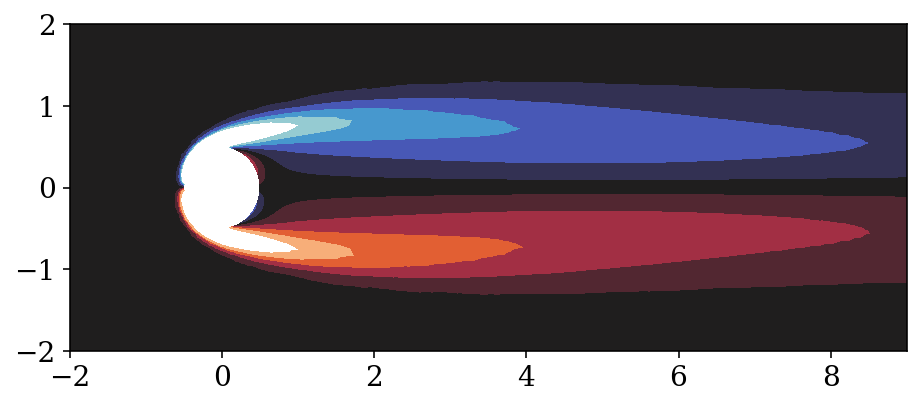

In [15]:
# Now we can't use `env.render()`, but it's easy to do something similar with firedrake
fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
levels = np.linspace(-3, 3, 10)
fd.tricontourf(cyl.vorticity(), levels=levels, axes=ax, cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-2, 9])
ax.set_ylim([-2, 2])
plt.show()

### I/O and callbacks

HydroGym implements a lot of input/output via "callbacks".  These are callable classes that will check the iteration count of the simulation and do something if it matches up with their internal clock.  Effectively this acts like a function like
```
def cb(iter, t, flow):
    # Do something with the flow
```
but it only gets called every `interval` steps, as defined when the object is initialized.

In [16]:
help(gym.core.CallbackBase)

Help on class CallbackBase in module hydrogym.core:

class CallbackBase(builtins.object)
 |  CallbackBase(interval: Union[int, NoneType] = 1)
 |  
 |  Methods defined here:
 |  
 |  __call__(self, iter: int, t: float, flow: hydrogym.core.FlowConfig)
 |      Check if this is an 'iostep' by comparing to `self.interval`
 |          This assumes that a child class will do something with this information
 |  
 |  __init__(self, interval: Union[int, NoneType] = 1)
 |      Base class for things that happen every so often in the simulation
 |      (e.g. save output for Paraview or write some info to a log file).
 |      See also `utils/io.py`
 |      
 |      Parameters:
 |          interval - how often to take action
 |  
 |  close(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if 

Simple callbacks can save a checkpoint or visualization file every so often, or write some custom output to a file.  You can also set up controllers with the callbacks, as we'll see in a minute.

You can set up a list of callbacks and pass them to either `ts.integrate` or `env.step`. For instance, suppose we want to write out a checkpoint every 5 steps.  The setup for this is just

In [17]:
output_dir = './demo_output'
chk = gym.io.CheckpointCallback(interval=5, filename=f'{output_dir}/checkpoint.h5')

In [18]:
!mkdir $output_dir
!ls $output_dir

As a slightly more complicated example, we can set up a callback to print some output to the terminal.  You can use a `LogCallback` for this:

In [19]:
# This is the function that will get called every time.
#   It should return a tuple or array of whatever you want logged
def log_postprocess(flow):
    return flow.collect_observations()
    
# Set up the callback
print_fmt = "t: {0},\t\t CL:{1:0.3f},\t\t CD:{2:0.03f}"  # This will format the output
log = gym.io.LogCallback(
    postprocess=log_postprocess,
    nvals=2,
    interval=1,
    print_fmt=print_fmt
)

We could also have set the log to save to a file by including a `filename` keyword argument.

Another common case is visualization in Paraview. The default behavior here is to write out the velocity and pressure, but it can also be modified with another `postprocess` function.  For instance, to also save vorticity every 5 steps:

In [20]:
def pvd_postprocess(flow):
    vort = flow.vorticity()
    return (flow.u, flow.p, vort)

pvd = gym.io.ParaviewCallback(
    postprocess=pvd_postprocess,
    interval=5,
    filename=f'{output_dir}/solution.pvd'
)

In [21]:
callbacks = [log, chk, pvd]

dt=1e-2
num_steps = 10
flow = gym.flow.Cylinder(h5_file=f'{precomputed_data}/checkpoint.h5')  # Same initial state as the `FlowEnv`
flow = gym.ts.integrate(flow, t_span=(0, num_steps*dt), dt=dt, callbacks=callbacks)
CL, CD = flow.compute_forces()   # Compute lift/drag, just as with env.collect_observations()

t: 0.0,		 CL:-0.236,		 CD:1.502
t: 0.01,		 CL:-0.232,		 CD:1.502
t: 0.02,		 CL:-0.229,		 CD:1.502
t: 0.03,		 CL:-0.226,		 CD:1.502
t: 0.04,		 CL:-0.222,		 CD:1.501
t: 0.05,		 CL:-0.219,		 CD:1.501
t: 0.06,		 CL:-0.215,		 CD:1.501
t: 0.07,		 CL:-0.212,		 CD:1.501
t: 0.08,		 CL:-0.208,		 CD:1.500
t: 0.09,		 CL:-0.205,		 CD:1.500


Now we should see the files appearing in the output directory

In [22]:
!ls $output_dir

checkpoint.h5  solution.pvd  solution_0.vtu  solution_1.vtu


The log output is still in the callback object, if we wanted it for anything.

In [23]:
log.data

array([[ 0.        , -0.23558152,  1.50219091],
       [ 0.01      , -0.23226524,  1.50196669],
       [ 0.02      , -0.22891954,  1.50173909],
       [ 0.03      , -0.22554485,  1.50150822],
       [ 0.04      , -0.22214158,  1.50127421],
       [ 0.05      , -0.21871014,  1.50103718],
       [ 0.06      , -0.21525096,  1.50079724],
       [ 0.07      , -0.21176446,  1.50055452],
       [ 0.08      , -0.20825106,  1.50030914],
       [ 0.09      , -0.2047112 ,  1.50006123]])

In [24]:
!rm -r $output_dir

### Differentiating through the solver

The solver is (or can be configured to be) differentiable with respect to many parameters by means of the [pyadjoint library](https://pyadjoint.readthedocs.io/en/release/documentation/pyadjoint_docs.html).  This is really set up for large-scale PDE-constrained optimization, but as a simple example we can take the derivative with respect to a proportional gain over a few timesteps (but note that this specific approach is *not* a good way to optimize gains... you effectively multiply the gain by itself many times and get numerical issues similar to what would happen if you naively tried to train a RNN).

Also note the `differentiable` flag on the environment initialization.  This selects a different timestepper `hydrogym.ts.IPCS_diff` that is slightly less efficient but allows for differentiating with respect to the boundary conditions, which is how the rotation control is implemented here.

In [3]:
import firedrake_adjoint as fda

In [5]:
env = gym.env.CylEnv(differentiable=True)
y = env.reset()

# Simple opposition control on lift
def feedback_ctrl(y, K=0.1):
    CL, CD = y
    return K*CL

K = fd.Constant(0.0)
J = fda.AdjFloat(0.0)
num_steps = 10
K = fd.Constant(0.1)
for _ in range(num_steps):
    u = K
    # u = feedback_ctrl(y, K=K)
    y, reward, done, info = env.step(u)
    J = J - reward
dK = fda.compute_gradient(J, fda.Control(K))
dK.values()

array([0.])

As another example that's more in line with the reverse-mode AD purpose of pyadjoint, we could compute the sensitivity of the final solution with respect to an initial condition.  We could just use the `FlowEnv`, but this shows you can do the same thing with the timestepping functionality. Again, note that the differentiable form of the IPCS solver is specified here.

In [ ]:
from firedrake import inner, dx
dt = 1e-2
num_steps = 10

cyl = gym.flow.Cylinder(h5_file=f'{precomputed_data}/checkpoint.h5')

# Store a copy of the initial condition to distinguish it from the time-varying solution
q0 = cyl.q.copy(deepcopy=True)
cyl.q.assign(q0, annotate=True)  # Note the annotation flag so that the assignment is tracked

# Time step forward as usual
cyl = gym.ts.integrate(cyl, t_span=(0, num_steps*dt), dt=dt, method='IPCS_diff')

# Define a cost functional... here we're just using the energy inner product
J = 0.5*fd.assemble(inner(cyl.u, cyl.u)*dx)

# Compute the gradient with respect to the initial condition
#   The option for Riesz representation here specifies that we should end up back in the primal space
dq = fda.compute_gradient(J, fda.Control(q0), options={"riesz_representation": "L2"})

In [ ]:
# Split out velocity and pressure components from the fields
u0, p0 = q0.split()
du, dp = dq.split()

fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
im = fd.tripcolor(u0, axes=ax, cmap=sns.color_palette("icefire", as_cmap=True))
ax.set_xlim([-2, 9])
ax.set_ylim([-2, 2])
plt.title('Initial velocity magnitude')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
im = fd.tripcolor(du, axes=ax, cmap=sns.color_palette("icefire", as_cmap=True))
plt.title('Sensitivity magnitude')
ax.set_xlim([-2, 9])
ax.set_ylim([-2, 2])
plt.show()